In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

# Выбор оптимальной модели

что делать, если наш оцениватель показывает недостаточно хорошие результаты?
Существует несколько возможных ответов:

- использовать более сложную/гибкую модель;
- применять менее сложную/гибкую модель;
-  собрать больше выборок для обучения;
- собрать больше данных для добавления новых признаков к каждой заданной
выборке.

**Компромисс между систематической ошибкой и дисперсией**

Выбор «оптимальной модели» состоит в поиске наилучшего компромисса между систематической ошибкой (bias) и дисперсией (variance)
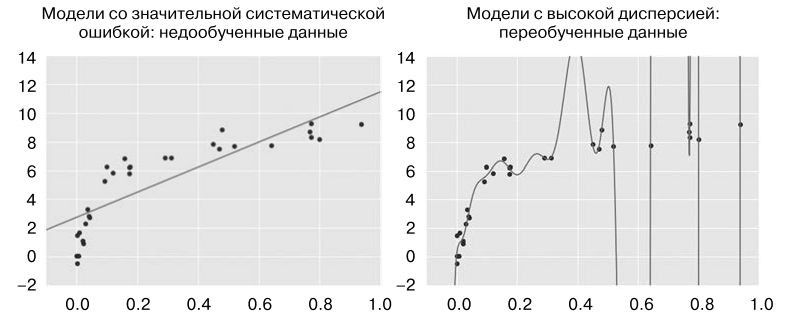

В качестве оценки эффективности используется $R^2$ — коэффициент детерминации или коэффициент смешанной корреляции. $R^2$ = 1 - идеальное совпадение предсказаний.
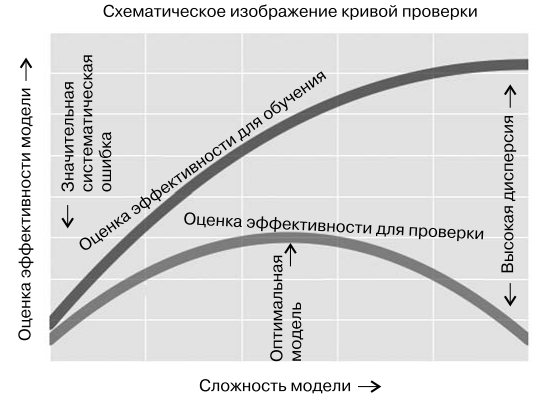

### Кривые обучения

In [2]:
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
# конвейер (pipeline) - соединение операций в единую цепочку

In [3]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(
        PolynomialFeatures(degree), 
        LinearRegression(**kwargs)
    )


In [4]:
# Создаем случайные выборки данных
N = 200
rng = np.random.RandomState(1)
X = rng.rand(N, 1) ** 2
y = 10 - 1. / (X.ravel() + 0.1) + 1 * rng.randn(N)

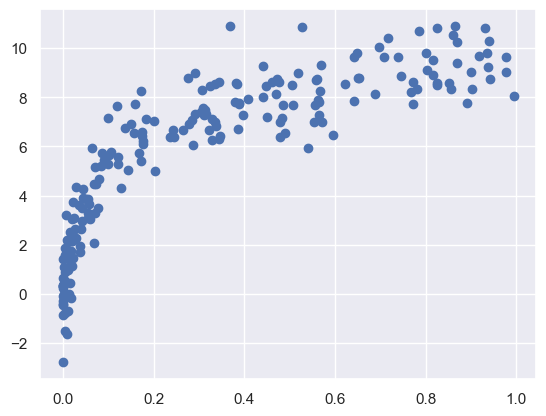

In [5]:
plt.scatter(X, y)

In [6]:
degree = np.arange(40)
train_score, val_score = validation_curve(
    PolynomialRegression(), 
    X, 
    y,
    param_name='polynomialfeatures__degree',
    param_range=degree,
    cv=7
)

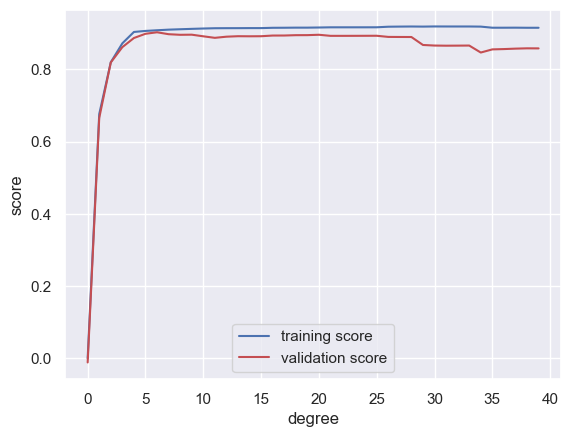

In [7]:
plt.plot(degree, np.median(train_score, 1), color='b', label='training score')
plt.plot(degree, np.median(val_score, 1), color='r', label='validation score')
plt.xlabel('degree')
plt.ylabel('score')
plt.legend(loc='lower center')

Из кривой проверки ясно, что этот больший набор данных позволяет использовать намного более сложную модель: максимум, вероятно, возле степени 6, но даже модель со степенью 20 не выглядит сильно переобученной — оценки эффективности для проверки и обучения остаются очень близки друг к другу.

### Кривая обучения

График оценок для обучения/проверки с учетом размера обучающей последовательности известен под названием кривой обучения (learning curve).

Поведение кривой обучения должно быть следующим.
- Модель заданной сложности окажется переобученной на слишком маленьком наборе данных. Это значит, что оценка эффективности для обучения будет относительно высокой, а оценка эффективности для проверки — относительно низкой.
- Модель заданной сложности окажется недообученной на слишком большом наборе данных. Это значит, что оценка эффективности для обучения будет снижаться, а оценка эффективности для проверки — повышаться по мере роста размера набора данных.
- Модель никогда, разве что случайно, не покажет на проверочном наборе лучший результат, чем на обучающей последовательности. Это значит, что кривые будут сближаться, но никогда не пересекутся.


In [17]:
# Создаем случайные выборки данных
N = 40
rng = np.random.RandomState(1)
X = rng.rand(N, 1) ** 2
y = 10 - 1. / (X.ravel() + 0.1) + 1 * rng.randn(N)

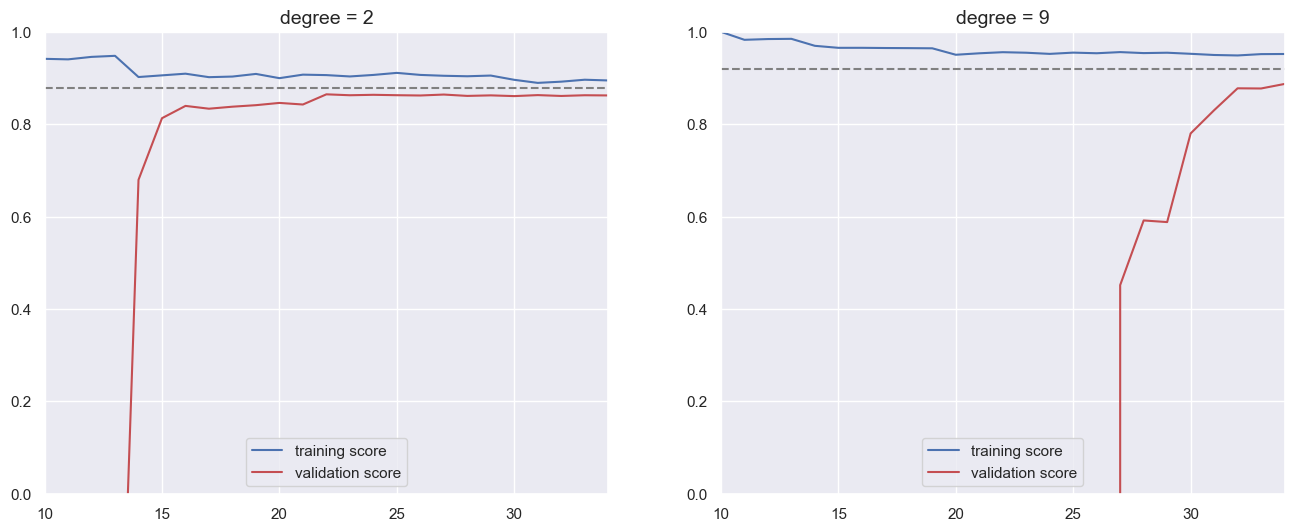

In [9]:
from sklearn.model_selection import learning_curve
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(
        PolynomialRegression(degree),
        X,
        y,
        cv=7,
        train_sizes=np.linspace(0.3, 1, 25)
    )
    ax[i].plot(N, np.mean(train_lc, 1), color='b', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='r', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1], 'gray', linestyle='--')
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].legend(loc='lower center')
    ax[i].set_title(f"degree = {degree}", size=14)

Данный показатель наглядно демонстрирует нам реакцию нашей модели на увеличение объема обучающих данных. 

После того момента, когда кривая обучения уже сошлась к какому-то значению (то есть когда кривые обучения и проверки уже близки друг к другу), добавление дополнительных обучающих данных не улучшит аппроксимацию существенно! Эта ситуация отражена на левом рисунке с кривой обучения для модели второй степени.

Единственный способ улучшения оценки уже сошедшейся кривой — использовать
другую (обычно более сложную) модель. Это видно на правом рисунке.

## Поиск по сетке

У моделей обычно больше одного параметра, необходимо отыскать конкретную модель, при которой оценка эффективности для проверки достигает максимума. Специальный автоматический инструмент - **grid_search**. 

In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'polynomialfeatures__degree': np.arange(21),
    'linearregression__fit_intercept': [True, False]
}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)
grid.fit(X, y)
grid.best_params_

{'linearregression__fit_intercept': False, 'polynomialfeatures__degree': 4}

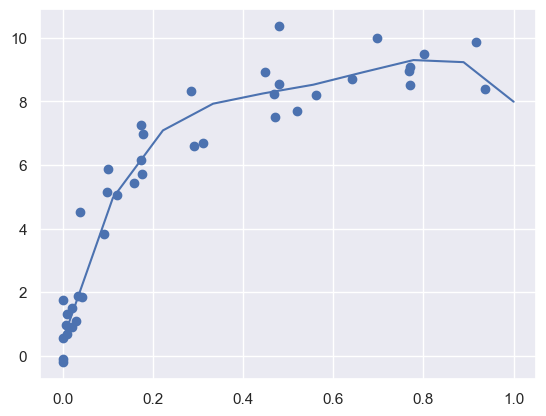

In [30]:
# воспользуемся этой оптимальной моделью
model = grid.best_estimator_

plt.scatter(X, y)
X_test = np.linspace(0, 1, 10)[:, np.newaxis]
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test, y_test)